In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [11]:
# Load clean dataset
df = pd.read_csv("datasets/compiled_merged_dataset/final_contact_tracing_data.csv")

print("Initial Shape:", df.shape)
print(df.head(3))

Initial Shape: (346845, 13)
   timestamp  person_A  person_B group_A group_B  time_seconds  time_minutes  \
0    28820.0       492       938     SRH    DMCT        576400   9606.666667   
1    28840.0       164       779     SSI     DST        576800   9613.333333   
2    28840.0       574      1362     DMI     DST        576800   9613.333333   

   time_hours        source_file             datetime        date      hour  \
0  160.111111  tij_InVS13_merged  2009-04-17 08:00:20  2009-04-17  08:00:20   
1  160.222222         tij_InVS15  2009-04-17 08:00:40  2009-04-17  08:00:40   
2  160.222222         tij_InVS15  2009-04-17 08:00:40  2009-04-17  08:00:40   

   timestamp_norm  
0         0.00000  
1         0.00002  
2         0.00002  


In [12]:
df = df[['person_A', 'person_B']]

# Just in case: remove self-links and handle missing values
df = df.dropna(subset=['person_A', 'person_B'])
df = df[df['person_A'] != df['person_B']]

print("After cleaning:", df.shape)
print(df.head(3))

After cleaning: (346845, 2)
   person_A  person_B
0       492       938
1       164       779
2       574      1362


In [15]:
# Build Contact Graph
G = nx.Graph()

# Add edges from person_A to person_B contacts
edges = list(zip(df['person_A'], df['person_B']))
G.add_edges_from(edges)

print(f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}")    

Nodes: 794
Edges: 20018


In [16]:
# Compute Degree Centrality
degree_centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Centrality'])
centrality_df = centrality_df.sort_values(by='Centrality', ascending=False)

print("\nTop 10 Most Central Nodes:")
print(centrality_df.head(10))


Top 10 Most Central Nodes:
     Node  Centrality
175  1599    0.213115
393  1688    0.211854
264  1655    0.205549
270  1441    0.199243
274  1825    0.196721
221   275    0.161412
298  1458    0.160151
144  1485    0.157629
284  1617    0.156368
8     267    0.156368


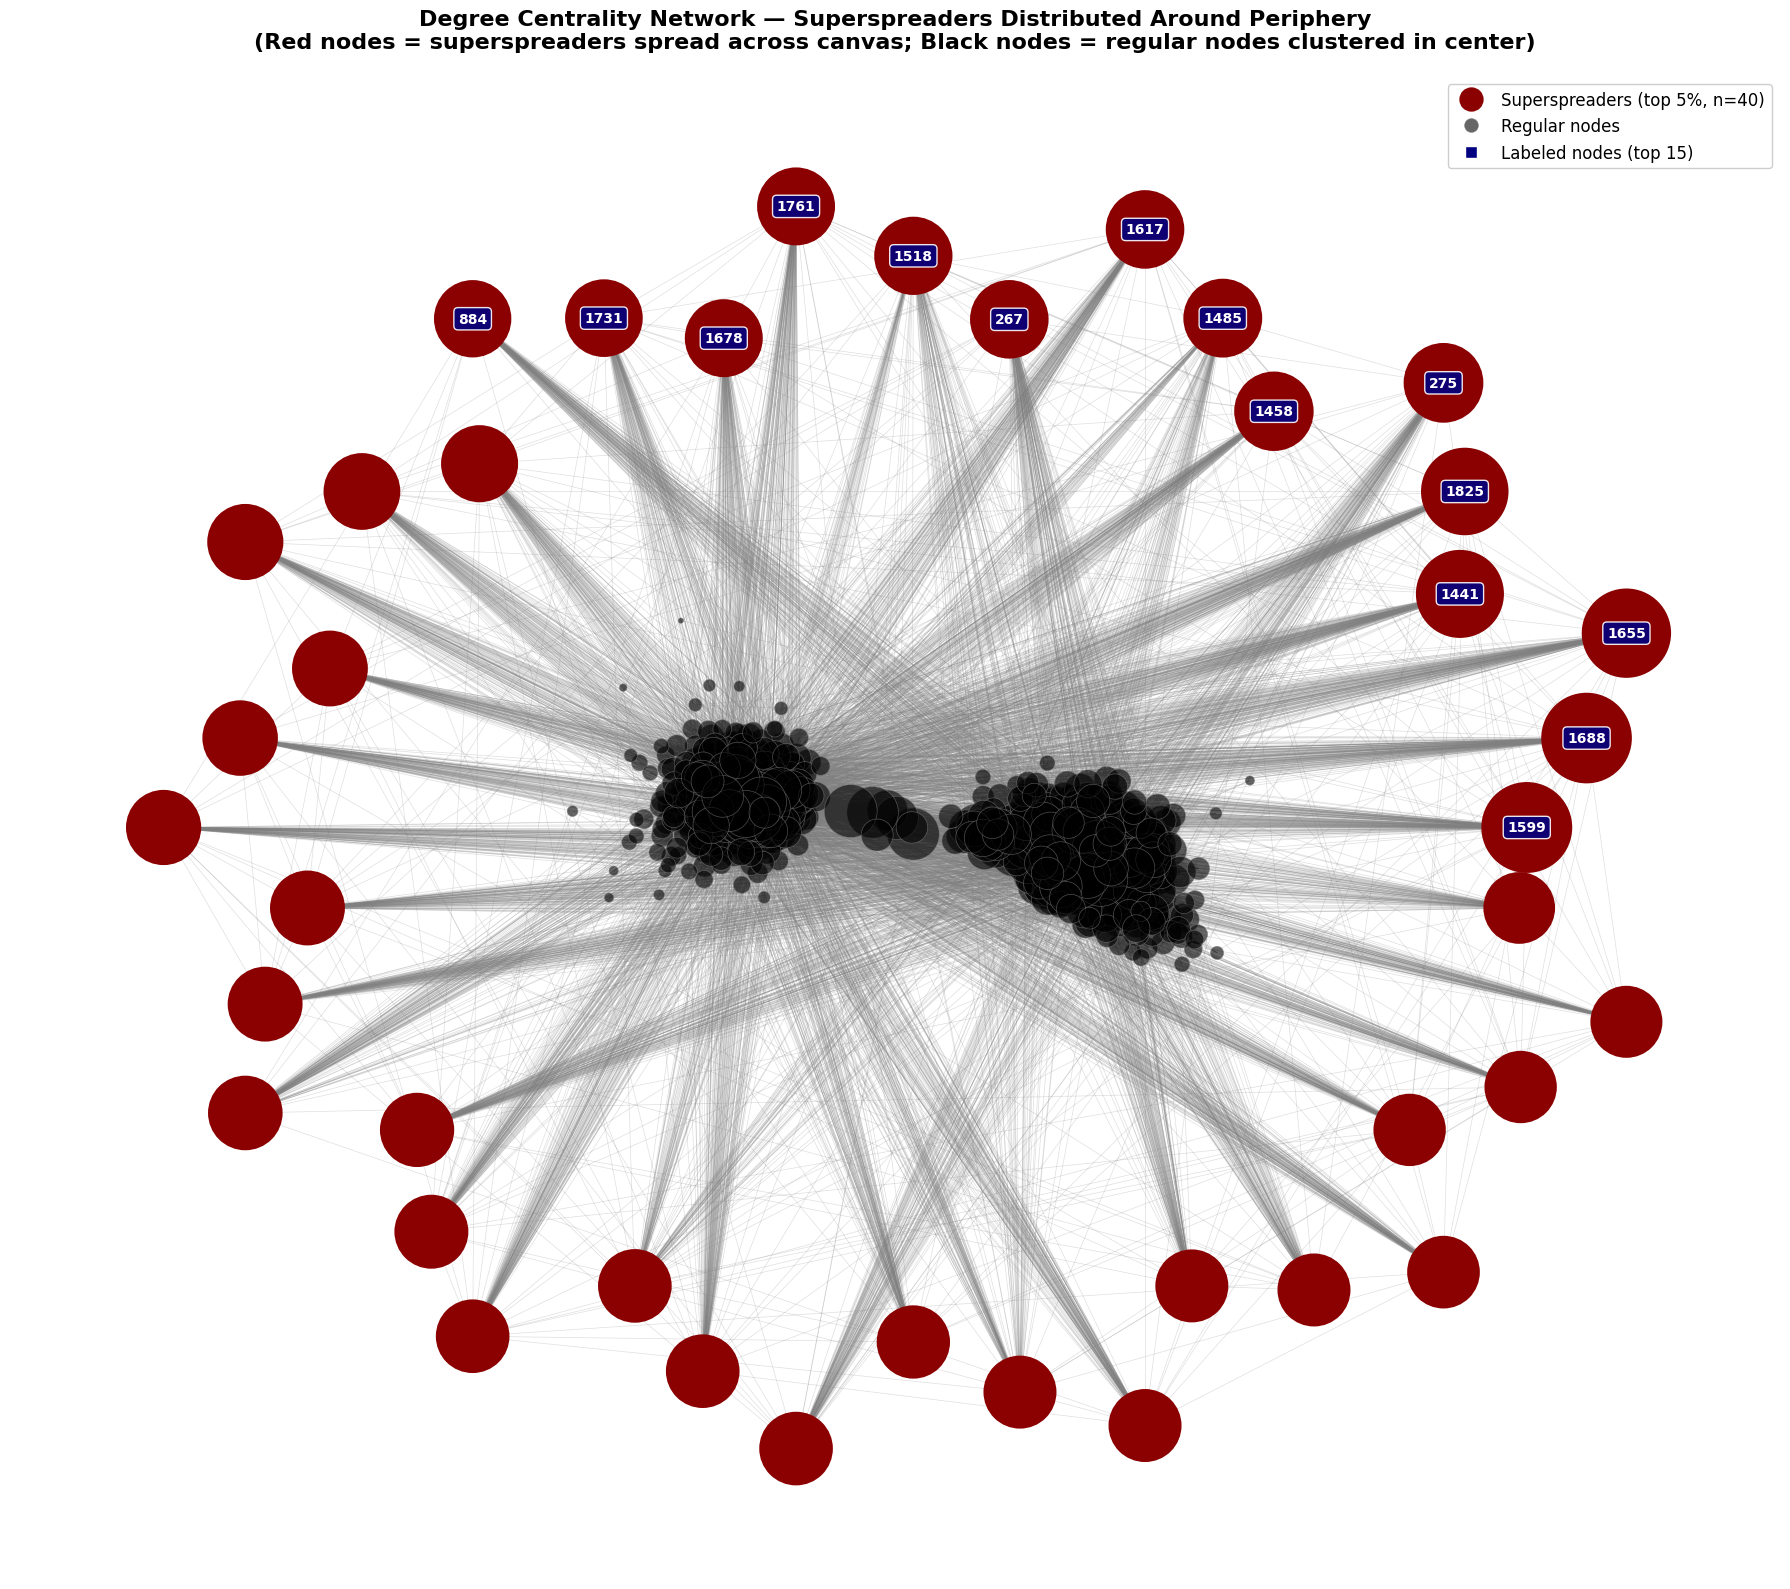

In [ ]:
# Network Graph Visualization with Superspreaders Spread Across Canvas
plt.figure(figsize=(18, 16))

# Start with a normal layout for all nodes
pos = nx.spring_layout(G, seed=42, k=0.3, iterations=50)

# Identify superspreaders (top 5% of nodes by centrality)
centrality_threshold = centrality_df['Centrality'].quantile(0.95)
superspreaders = centrality_df[centrality_df['Centrality'] >= centrality_threshold]['Node'].tolist()

# Dramatically spread out superspreaders across the entire canvas
for i, node in enumerate(superspreaders):
    # Distribute superspreaders in a circular pattern around the periphery
    angle = 2 * np.pi * i / len(superspreaders)
    # Place them far from center (radius = 1.8 to 2.2)
    radius = 1.8 + 0.4 * (i % 3) / 2  # Vary radius slightly
    pos[node] = np.array([radius * np.cos(angle), radius * np.sin(angle)])

# Draw edges with better visibility
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color='gray', width=0.5)

# Draw regular nodes in BLACK/DARK GRAY (clustered in center)
regular_nodes = [n for n in G.nodes() if n not in superspreaders]
regular_sizes = [degree_centrality[n] * 12000 for n in regular_nodes]

if regular_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, 
                          node_size=regular_sizes, node_color='black',
                          alpha=0.6, edgecolors='gray', linewidths=0.5)

# Draw superspreaders in RED with thick borders (spread across canvas)
superspreader_sizes = [degree_centrality[n] * 18000 for n in superspreaders]

if superspreaders:
    nx.draw_networkx_nodes(G, pos, nodelist=superspreaders,
                          node_size=superspreader_sizes, node_color='darkred',
                          alpha=1.0, edgecolors='darkred', linewidths=3.5)

# Add labels for top 15 nodes with better visibility
top_15_nodes = centrality_df.head(15)['Node'].tolist()
labels = {node: str(node) for node in top_15_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold', 
                        font_color='white', 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='navy', 
                                 edgecolor='white', alpha=0.9))

# Add informative legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', 
           markersize=14, markeredgecolor='darkred', markeredgewidth=3.5,
           label=f'Superspreaders (top 5%, n={len(superspreaders)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
           markersize=10, markeredgecolor='gray', markeredgewidth=0.5, alpha=0.6,
           label='Regular nodes'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='navy', 
           markersize=8, markeredgecolor='white', markeredgewidth=1,
           label='Labeled nodes (top 15)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.95)

plt.title("Degree Centrality Network — Superspreaders Distributed Around Periphery\n(Red nodes = superspreaders spread across canvas; Black nodes = regular nodes clustered in center)", 
          fontsize=16, fontweight='bold', pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()
